## Download the data from GWOSC

In [34]:
import os

for url in (
    'https://zenodo.org/record/6513631/files/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5',
    'https://zenodo.org/record/5636816/files/o1%2Bo2%2Bo3_bbhpop_real%2Bsemianalytic-LIGO-T2100377-v2.hdf5',
    ):
    file = url.split('files/')[1].replace('%2B', '+')
    if not os.path.exists('./data/' + file):
        os.system(f'wget -P ./data/ {url}')

## Install popodds

In [2]:
try:
    os.system('pip install -e ..')
except:
    os.system('pip install -U popodds')

Obtaining file:///home/ADF/mdm988/matt/code/popodds
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: popodds
    Found existing installation: popodds 0.5.2
    Uninstalling popodds-0.5.2:
      Successfully uninstalled popodds-0.5.2
  Running setup.py develop for popodds


In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from kaydee import KDE
import popodds

## Population model

In [4]:
def powerlaw(x, lo, hi, slope):
    
    shape = x**slope
    norm = (slope + 1) / (hi**(slope + 1) - lo**(slope + 1))
    cut = (lo < x) * (x < hi)
    
    return shape * norm * cut

def model(x, m_min, m_max, m_slope, q_slope):
    
    m1, q = x
    p_m1 = powerlaw(m1, m_min, m_max, m_slope)
    p_q = powerlaw(q, m_min/m1, 1, q_slope)
    
    return p_m1 * p_q

## GW150914 parameter estimation samples

In [5]:
file = './data/IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo.h5'
with h5py.File(file, 'r') as h:
    pos = h['C01:IMRPhenomXPHM']['posterior_samples']
    
    m1 = pos['mass_1_source']
    q = pos['mass_ratio']
    samples = np.array([m1, q])
    
    m1z = pos['mass_1']
    m2z = pos['mass_2']
    samples_z = np.array([m1z, m2z])
    
    z = pos['redshift'][:]
    
    pri = h['C01:IMRPhenomXPHM']['priors']['samples']
    samples_pri = np.array([pri['mass_1'], pri['mass_2']])

In [6]:
print(samples.shape)
print(samples_pri.shape)

(2, 147634)
(2, 5000)


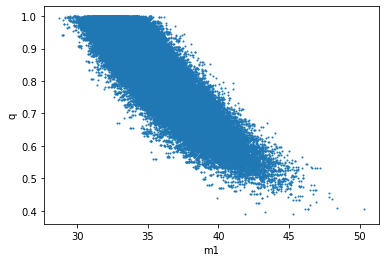

In [35]:
# The m1--q posterior

plt.scatter(*samples, s=1)
plt.xlabel('m1')
plt.ylabel('q');

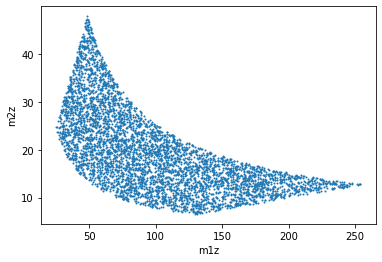

In [36]:
# The m1z--m2z prior
# As we can see, there are mass cuts in the (detector-frame) prior

plt.scatter(*samples_pri, s=1)
plt.xlabel('m1z')
plt.ylabel('m2z');

In [9]:
# The Jacobian for (m1z, m2z, z) -> (m1, q, z) is m1(1+z)^2
# The prior p(m1z, m2z) is flat inside the cuts
# We assume a redshift model equal to the PE prior so it cancels

# PE prior evaluated at posterior sample locations
# This only captures the prior shape, not the normalization
# We don't need the prior normalization when comparing two models as it cancels
# But we do need it if we just compare one model to the PE prior

prior_nonorm_ = m1 * (1 + z)**2
prior_nonorm = lambda x: prior_nonorm_

In [10]:
# We can also estimate the normalized prior

kde = KDE(samples_pri)
prior_kde_ = kde.pdf(samples_z) * prior_nonorm_
prior_kde = lambda x: prior_kde_

## Without selection effects

In [11]:
# Define the astrophysical model

modelA = lambda x: model(x, m_min=2, m_max=40, m_slope=-2, q_slope=0)

In [12]:
# Compute the log Bayes factor for modelA over the PE prior

# Wrong! Because the prior is not normalized
log_bf_nonorm = popodds.log_odds(modelA, prior_nonorm, samples, log=False)
print(log_bf_nonorm)

# With prior normalized
log_bf_kde = popodds.log_odds(modelA, prior_kde, samples, log=False)
print(log_bf_kde)

-10.066673649552595
-1.6297781459102332


/home/ADF/mdm988/matt/code/popodds/popodds/__init__.py:215: RuntimeWarning: divide by zero encountered in log
  model = np.log(model)


In [32]:
# Now define a second astrophysical model

modelB = lambda x: model(x, m_min=2, m_max=40, m_slope=-3, q_slope=1)

In [33]:
# Compute the log Bayes factor for modelA over modelB

# The prior normalization is constant and cancels
log_bfAB_nonorm = popodds.log_odds(
    modelA, prior_nonorm, samples, log=False, second_model=modelB,
    )
print(log_bfAB_nonorm)

# This is roughly the same up to errors from the prior KDE
log_bfAB_kde = popodds.log_odds(
    modelA, prior_kde, samples, log=False, second_model=modelB,
    )
print(log_bfAB_kde)

1.71445066377
1.6830374335159988


## With selection effects

In [125]:
# We compute population detection fractions by reweighting recovered injections

cut_far = 1
cut_snr = 12

file = './data/o1+o2+o3_bbhpop_real+semianalytic-LIGO-T2100377-v2.hdf5'
with h5py.File(file, 'r') as h:
    
    # Actually, we don't need to know the total (detectable + not detectable)
    # number of injections, becaues it cancels
    # n_total = h.attrs['total_generated']
    
    d = h['injections']
    
    ifars = np.max([d[par][:] for par in d if 'ifar' in par], axis=0)
    snrs = d['optimal_snr_net'][:]
    obs_runs = d['name'][:].astype(str)
    found = np.where(obs_runs == 'o3', ifars > 1/cut_far, snrs > cut_snr)
    
    m1 = d['mass1_source'][:][found]
    m2 = d['mass2_source'][:][found]
    s1x = d['spin1x'][:][found]
    s1y = d['spin1y'][:][found]
    s1z = d['spin1z'][:][found]
    s2x = d['spin2x'][:][found]
    s2y = d['spin2y'][:][found]
    s2z = d['spin2z'][:][found]
    z = d['redshift'][:][found]
        
    # See https://zenodo.org/record/5546676 for the injection distribution
    # sampling_pdf is the injected p(m1, m2, s1x, s1y, s1z, s2x, s2y, s2z, z)
    # We model p(m1, m2), but we also assume a z model equal to the PE prior
    # The z PE prior is different to the injected distribution

    p = d['sampling_pdf'][:][found]

In [136]:
pow_mass1 = -2.35
min_mass1 = 2
max_mass1 = 100
min_mass2 = 2
pow_mass2 = 1

def p_m(m1, m2):

    p1 = m1**pow_mass1 * (min_mass1 <= m1) * (m1 <= max_mass1)
    p2 = m2**pow_mass2 * (min_mass2 <= m2) * (m2 <= m1)
    
    norm = (
        max_mass1**(pow_mass1+1) * (
            max_mass1**(pow_mass2+1) / (pow_mass1+pow_mass2+2) -
            min_mass2**(pow_mass2+1) / (pow_mass1+1)
            ) -
        min_mass1**(pow_mass1+1) * (
            min_mass1**(pow_mass2+1) / (pow_mass1+pow_mass2+2) -
            min_mass2**(pow_mass2+1) / (pow_mass1+1)
            )
        ) / (pow_mass2+1)
    
    return p1 * p2 / norm

In [137]:
max_spin = 0.998

def p_s(sx, sy, sz):
    
    ssq = sx**2 + sy**2 + sz**2
    
    return (ssq <= max_spin**2) / 4 / np.pi / ssq / max_spin

In [138]:
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d
from scipy.integrate import quad

class PowerlawRedshift:

    def __init__(self, z_min=0, z_max=1.9, z_pow=1):

        self.z_min = z_min
        self.z_max = z_max
        self.z_pow = z_pow
        
        zs = np.linspace(z_min, z.max(), 5000)
        dVdz = Planck15.differential_comoving_volume(zs).value #* 4 * np.pi
        self.dVdz = interp1d(zs, dVdz)
        self.norm = quad(self.model, z_min, z_max)[0]

    def model(self, z):
        
        return self.dVdz(z) * (1 + z)**(self.z_pow - 1)

    def prob(self, z):

        return (self.z_min < z) * (z < self.z_max) * self.model(z) / self.norm
    
z_pow = 1
z_max = 1.9

p_z = PowerlawRedshift(z_max=z_max, z_pow=z_pow).prob

In [139]:
p

array([5.08844182e-07, 2.02310968e-06, 1.98497068e-05, ...,
       6.22318655e-07, 2.61628606e-04, 2.88339823e-07])

In [142]:
p_m(m1, m2) * p_s(s1x, s1y, s1z) * p_s(s2x, s2y, s2z) * p_z(z) / p

array([1.62786240e-06, 1.63926452e-05, 2.56679049e-04, ...,
       4.48198402e-06, 1.15415733e-02, 2.45892567e-06])

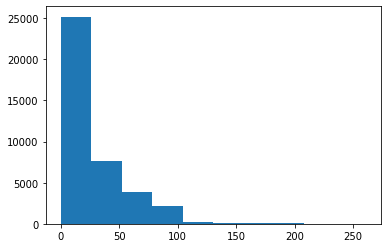

In [143]:
plt.hist(p_m(m1, m2) * p_s(s1x, s1y, s1z) * p_s(s2x, s2y, s2z) * p_z(z) / p);